In [ ]:
from pyspark.sql.types import StructType, StructField, DateType, FloatType
from pyspark.sql.functions import to_date

#  Definisanje seme
inflation_schema = StructType([
    StructField("Date", DateType(), True),
    StructField("InflationRate", FloatType(), True)
])

# UCitavanje podataka
inflation_data = spark.read.csv("dbfs:/FileStore/federalAndInflation/inflationRateData.csv",
                                schema=inflation_schema,
                                header=True)

# Konvertovanje datuma
inflation_data = inflation_data.withColumn("Date", to_date(inflation_data["Date"], "yyyy-MM-dd"))

inflation_data.show()

+----------+-------------+
|      Date|InflationRate|
+----------+-------------+
|2009-01-01|  -0.35554627|
|2008-01-01|    3.8391004|
|2003-01-01|    2.2700949|
|2001-01-01|    2.8261712|
|2000-01-01|    3.3768573|
|1998-01-01|    1.5522791|
|1995-01-01|    2.8054197|
|1988-01-01|     4.077741|
|1987-01-01|    3.6645632|
|1983-01-01|    3.2124352|
|1976-01-01|    5.7448125|
|1969-01-01|     5.462386|
|1966-01-01|    3.0150754|
|1965-01-01|    1.5851693|
|1964-01-01|    1.2789116|
|1960-01-01|     1.457976|
|2018-01-01|    2.4425833|
|2009-01-01|  -0.35554627|
|2008-01-01|    3.8391004|
|2003-01-01|    2.2700949|
+----------+-------------+
only showing top 20 rows



In [ ]:
#  Definisanje seme
funds_rate_schema = StructType([
    StructField("Date", DateType(), True),
    StructField("FundsRate", FloatType(), True)
])

# Ucitavanje podataka
funds_rate_data = spark.read.csv("dbfs:/FileStore/federalAndInflation/federalFundsRateData.csv",
                                 schema=funds_rate_schema,
                                 header=True)

# Konvertovanje datuma
funds_rate_data = funds_rate_data.withColumn("Date", to_date(funds_rate_data["Date"], "yyyy-MM-dd"))

funds_rate_data.show()


+----------+---------+
|      Date|FundsRate|
+----------+---------+
|2023-10-01|     5.33|
|2022-10-01|     3.08|
|2022-09-01|     2.56|
|2022-02-01|     0.08|
|2021-12-01|     0.08|
|2021-10-01|     0.08|
|2021-07-01|      0.1|
|2020-10-01|     0.09|
|2020-09-01|     0.09|
|2020-07-01|     0.09|
|2020-05-01|     0.05|
|2020-03-01|     0.65|
|2019-07-01|      2.4|
|2018-12-01|     2.27|
|2018-10-01|     2.19|
|2018-08-01|     1.91|
|2018-06-01|     1.82|
|2018-02-01|     1.42|
|2018-01-01|     1.41|
|2017-12-01|      1.3|
+----------+---------+
only showing top 20 rows



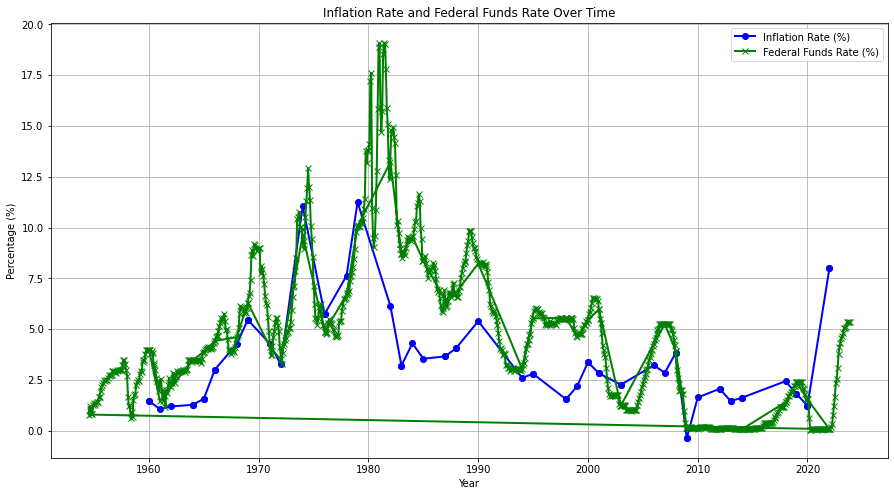

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Konverzija Spark DataFrame-a u Pandas DataFrame
inflation_pd = inflation_data.toPandas()
funds_rate_pd = funds_rate_data.toPandas()

# Sortiranje Podataka po Datumu
inflation_pd = inflation_pd.sort_values(by="Date")
funds_rate_pd = funds_rate_pd.sort_values(by="Date")


# Spajanje Dva Skupa Podataka
combined_data = pd.merge(inflation_pd, funds_rate_pd, on='Date', how='outer')

# Plotovanje svega na istom grafiku
plt.figure(figsize=(15, 8))

# Inflation Rate
plt.plot(combined_data['Date'], combined_data['InflationRate'], label='Inflation Rate (%)', color='blue', marker='o', linestyle='-', linewidth=2, markersize=6)

# Federal Funds Rate
plt.plot(combined_data['Date'], combined_data['FundsRate'], label='Federal Funds Rate (%)', color='green', marker='x', linestyle='-', linewidth=2, markersize=6)

plt.title('Inflation Rate and Federal Funds Rate Over Time')
plt.xlabel('Year')
plt.ylabel('Percentage (%)')
plt.legend()
plt.grid(True)
plt.show()
# Na osnovu ovog grafika mozemo da vidimo da je inflacija delimicno povezana sa kamatnim stopama. Vidimo da ukoliko su kamatne stope visoke da je tada inflacija relativno u opadanju. Dizanjem kamatnih stopa, krediti postaju skuplji i zbog toga vise ljudi nece da ih uzme sto znaci da se smanjuje kolicina novca koja je u opticaju. Posto ima manje novca, a znamo svi da kad je necega manje a svi ga zelimo da mu vrednost skace i samim tim se inflacija smanjuje.

Mean Squared Error: 1.319172
R-squared: 0.19344697253556842


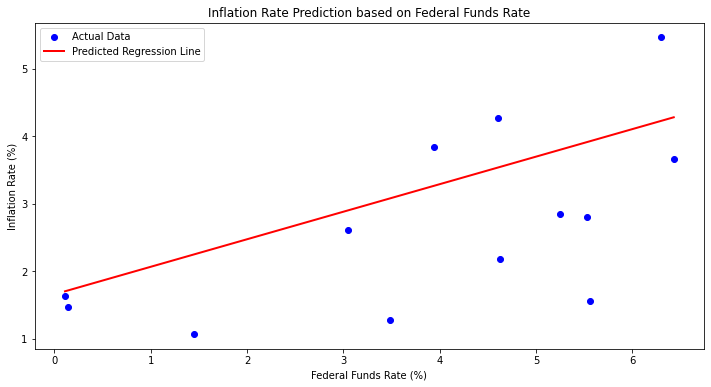

In [ ]:
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Spajanje Dva Skupa Podataka
combined_data = pd.merge(inflation_pd[['Date', 'InflationRate']], funds_rate_pd[['Date', 'FundsRate']], on='Date', how='inner')

# Uklanjanje Nedostajućih Vrednosti
combined_data.dropna(inplace=True)


# Kao feature se uzima fundsRate a predvidjamo inflaciju
X = combined_data[['FundsRate']]
y = combined_data['InflationRate']

# Podela Podataka na Trening i Test Skupove
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Obučavanje Linearnog Regresijskog Modela
model = LinearRegression()
model.fit(X_train, y_train)

# Testiranje koliko ce dobro predvideti vrednosti inflacije
y_pred = model.predict(X_test)

# Provera rezultata
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# MSE nam ukazuje na srednju kvadratnu gresku izmedju stvarnih i predvidjenih vrednosti, sto je niza vrednost MSE ukazuje na bolju tacnost modela. Ovde je MSE relativno jako
# visok tako da nismo uspeli da dobijemo najtacniji model za predvidjanje
print("Mean Squared Error:", mse )
# R-kvadrat meri koliko dobro predviđanja modela odgovaraju stvarnim podacima. U idealnom slučaju, R-kvadrat bi trebao biti što bliži 1. Vrednost od oko 0.19 ukazuje na to da
# model objašnjava samo oko 19.3% varijabilnosti stope inflacije. To je prilično nisko i sugeriše da mnogi drugi faktori koji utiču na inflaciju nisu uključeni u model.
print("R-squared:", r2) #


# Plotovanje
plt.figure(figsize=(12, 6))
plt.scatter(X_test['FundsRate'], y_test, color='blue', label='Actual Data')

# Geenrisemo regresionu liniju na osnovu test podataka
X_test_sorted = X_test.sort_values(by='FundsRate')
y_pred_sorted = model.predict(X_test_sorted)

# Plotovanje
plt.plot(X_test_sorted['FundsRate'], y_pred_sorted, color='red', linewidth=2, label='Predicted Regression Line')

plt.title('Inflation Rate Prediction based on Federal Funds Rate')
plt.xlabel('Federal Funds Rate (%)')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.show()


# Zakljucak je da ne mozemo na osnovu kamatne stope da zakljucimo kakva ce biti inflacija, ima deo koji utice na inflaciju ali svakako postoji i dosta faktora koji uticu takodje na inflaciju a nisu ukljuceni u nas model.

In [ ]:
# Izračunavanje Pearsonovog Koeficijenta Korelacije  -  Rezultat je broj između -1 i 1. Koeficijent blizu 1 ukazuje na jaku pozitivnu korelaciju, blizu -1 na jaku negativnu korelaciju, a blizu 0 ukazuje na slabu ili nikakvu korelaciju. Cilj je utvrditi postoji li i koliko je jaka statistička veza između stope inflacije i Federalne kamatne stope. Posto je korelacija 0.53 to ukazuje na umereno pozitivnu korelaciju izmedju ove dve varijable.
correlation_matrix = combined_data[['InflationRate', 'FundsRate']].corr()
correlation_value = correlation_matrix.loc['InflationRate', 'FundsRate']

print(f"The Pearson correlation coefficient between Inflation Rate and Federal Funds Rate is: {correlation_value}")

The Pearson correlation coefficient between Inflation Rate and Federal Funds Rate is: 0.534444701497962


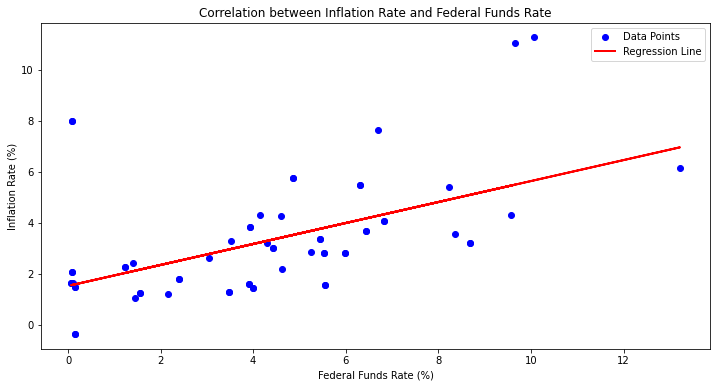

In [ ]:
plt.figure(figsize=(12, 6))

# scatter plota se koristi da prikazuje svaki par podataka (Federalna kamatna stopa i stopa inflacije) kao tačku na grafikonu
plt.scatter(combined_data['FundsRate'], combined_data['InflationRate'], color='blue', label='Data Points')

# funkcija np.polyfit se koristi za pronalaženje koeficijenata linearnog polinoma (linije regresije) koji najbolje odgovara podacima. np.poly1d koristi ove koeficijente za stvaranje funkcije linije regresije.
z = np.polyfit(combined_data['FundsRate'], combined_data['InflationRate'], 1)
p = np.poly1d(z)
plt.plot(combined_data['FundsRate'], p(combined_data['FundsRate']), color='red', linewidth=2, label='Regression Line')

plt.title('Correlation between Inflation Rate and Federal Funds Rate')
plt.xlabel('Federal Funds Rate (%)')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.show()

# Cilj je istražiti postoji li vizuelno uočljiva korelacija između stope inflacije. Vidimo da se delimicno uocava povezanost ali da ima dosta izuzetaka.

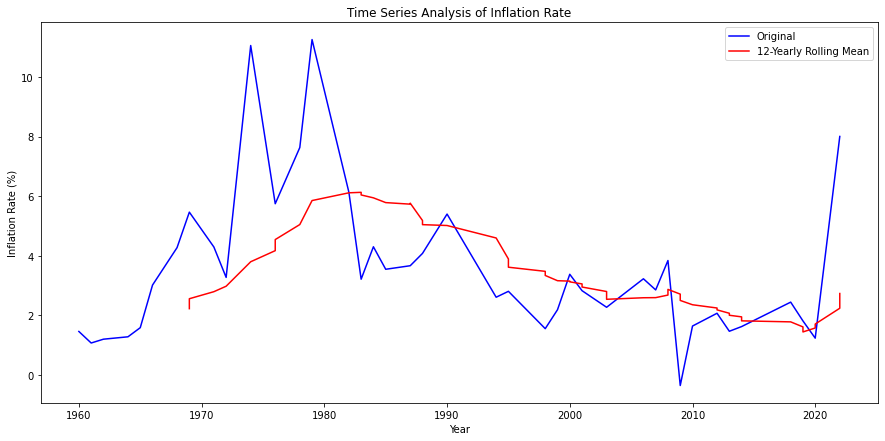

In [ ]:
# Konverzija 'Date' u DateTime i Postavljanje kao Indeks
inflation_pd['Date'] = pd.to_datetime(inflation_pd['Date'])
inflation_pd.set_index('Date', inplace=True)

# Sortiranje DataFrame-a po Datumu
inflation_pd.sort_index(inplace=True)

# Izračunavanje 12-Godisnjeg Pokretnog Proseka
rolling_mean = inflation_pd['InflationRate'].rolling(window=12).mean()
plt.figure(figsize=(15, 7))

# Vizualizacija
plt.plot(inflation_pd['InflationRate'], label='Original', color='blue')

plt.plot(rolling_mean, label='12-Yearly Rolling Mean', color='red')

plt.title('Time Series Analysis of Inflation Rate')
plt.xlabel('Year')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.show()
# Cilj je analizirati trendove stope inflacije tokom vremena, razlikujući kratkoročne promene od dugoročnih trendova. Analiza se koristi za bolje razumevanje dinamike inflacije, što je ključno za ekonomske analize, planiranje politika i investicione odluke.
# Vizuelizacija pruža jasan prikaz kako se stopa inflacije menja tokom vremena. Pokretni prosek pomaže u identifikaciji dugoročnih trendova, što može biti teško uočiti u dnevnim ili mesečnim fluktuacijama podataka.

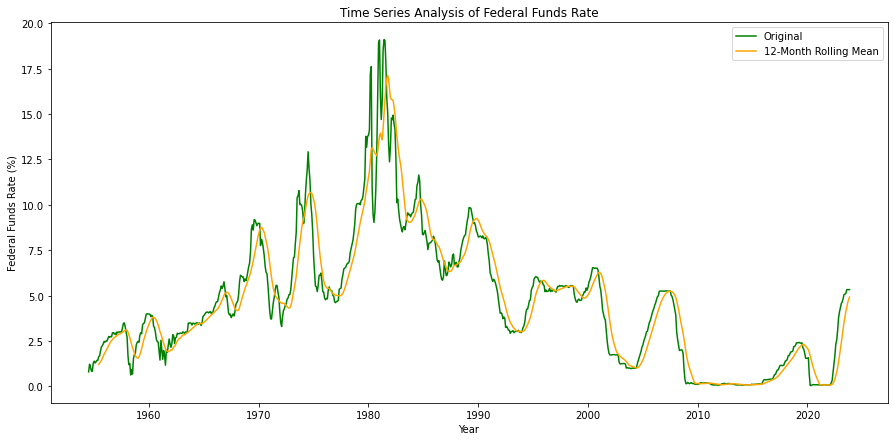

In [ ]:
# Konverzija 'Date' u DateTime i Postavljanje kao Indeks
funds_rate_pd['Date'] = pd.to_datetime(funds_rate_pd['Date'])
funds_rate_pd.set_index('Date', inplace=True)

# Sortiranje DataFrame-a po Datumu
funds_rate_pd.sort_index(inplace=True)

# Izračunavanje 12-Mesečnog Pokretnog Proseka
rolling_mean_funds_rate = funds_rate_pd['FundsRate'].rolling(window=12).mean()

plt.figure(figsize=(15, 7))

# Vizualizacija
plt.plot(funds_rate_pd['FundsRate'], label='Original', color='green')

plt.plot(rolling_mean_funds_rate, label='12-Month Rolling Mean', color='orange')

plt.title('Time Series Analysis of Federal Funds Rate')
plt.xlabel('Year')
plt.ylabel('Federal Funds Rate (%)')
plt.legend()
plt.show()

# Cilj je analizirati trendove kamatnih stopa tokom vremena, razlikujući kratkoročne promene od dugoročnih trendova. Analiza se koristi za bolje razumevanje dinamike kamatnih stopa, što je ključno za ekonomske analize, planiranje politika i investicione odluke.
# Vizuelizacija pruža jasan prikaz kako se kamatne menja tokom vremena. Pokretni prosek pomaže u identifikaciji dugoročnih trendova, što može biti teško uočiti u dnevnim ili mesečnim fluktuacijama podataka.

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Primena Augmented Dickey-Fuller Testa
result = adfuller(funds_rate_pd['FundsRate'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

if result[1] > 0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")

# Cilj je utvrditi da li je vremenska zavisnost Federalne kamatne stope stacionarna ili ne.
# Stacionarnost u kontekstu vremenskih zavisnosti je koncept koji se odnosi na to da statistička svojstva serije, poput srednje vrednosti, varijanse i kovarijanse, ostaju konstantna tokom vremena. Drugim rečima, stacionarna vremenska serija ne pokazuje trendove, sezonske varijacije ili promene u varijansi tokom vremena.
# Ne-stacionarne serije mogu imati promenljive srednje vrednosti, varijanse ili trendove tokom vremena, što otežava analizu i modeliranje. Stacionarne serije su stabilnije i lakše za modeliranje.
# Ako je p-vrednost veća od 0.05, vremenska serija se smatra ne-stacionarnom.
# Stacionarnost je važna pretpostavka u mnogim statističkim modelima za vremenske serije, kao što su ARIMA modeli.

ADF Statistic: -2.952134
p-value: 0.039613
Series is stationary


In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# ARIMA (AutoRegressive Integrated Moving Average) modela za vremensku zavisnost Federalne kamatne stope
# Definisanje ARIMA Modela (example parameters: p=1, d=1, q=1)
model = ARIMA(funds_rate_pd['FundsRate'], order=(1, 1, 1))
model_fit = model.fit()

# Cilj je modelirati vremensku zavisnosti Federalne kamatne stope i koristiti model za predviđanje njenih budućih vrednosti. ARIMA modeli su moćni alati za analizu i predviđanje vremenskih serija, posebno u ekonomiji i finansijama.

In [ ]:
# Predvidjanje vrednosti pomocu istreniranog modela
forecast = model_fit.forecast(steps=5)
print(forecast)

2023-12-01    5.326499
2024-01-01    5.326140
2024-02-01    5.326103
2024-03-01    5.326099
2024-04-01    5.326099
Freq: MS, Name: predicted_mean, dtype: float64


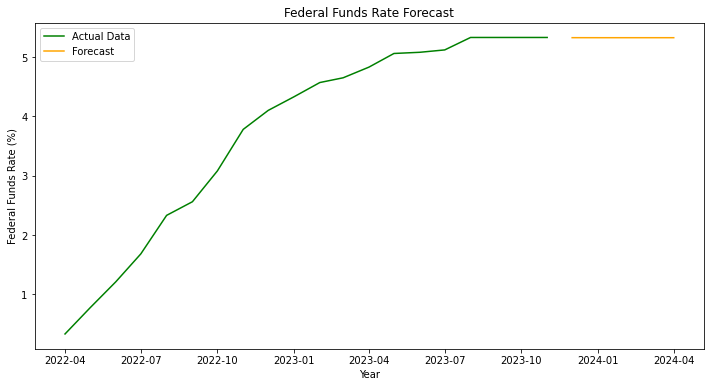

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(funds_rate_pd['FundsRate'][-20:], label='Actual Data', color='green')

last_date = funds_rate_pd.index[-1]
future_dates = [last_date + pd.DateOffset(months=i) for i in range(1,6)]

plt.plot(future_dates, forecast, label='Forecast', color='orange')

plt.title('Federal Funds Rate Forecast')
plt.xlabel('Year')
plt.ylabel('Federal Funds Rate (%)')
plt.legend()
plt.show()

In [ ]:
# Primena Augmented Dickey-Fuller Testa
result = adfuller(inflation_pd['InflationRate'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


if result[1] > 0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")


# Cilj je utvrditi da li je vremenska zavisnost Inflacije stacionarna ili ne.
# Stacionarnost u kontekstu vremenskih zavisnost je koncept koji se odnosi na to da statistička svojstva zavisnost, poput srednje vrednosti, varijanse i kovarijanse, ostaju konstantna tokom vremena. Drugim rečima, stacionarna vremenska serija ne pokazuje trendove, sezonske varijacije ili promene u varijansi tokom vremena.
# Ne-stacionarne serije mogu imati promenljive srednje vrednosti, varijanse ili trendove tokom vremena, što otežava analizu i modeliranje. Stacionarne serije su stabilnije i lakše za modeliranje.
# Ako je p-vrednost veća od 0.05, vremenska zavisnost se smatra ne-stacionarnom.
# Stacionarnost je važna pretpostavka u mnogim statističkim modelima za vremenske serije, kao što su ARIMA modeli.

In [ ]:
# ARIMA (AutoRegressive Integrated Moving Average) modela za vremensku zavisnost
# Definisanje ARIMA Modela (example parameters: p=1, d=1, q=1)
model_inflation = ARIMA(inflation_pd['InflationRate'], order=(1, 1, 1))
model_inflation_fit = model_inflation.fit()


In [ ]:
# Predvidjanje vrednosti pomocu istreniranog modela
forecast_inflation = model_inflation_fit.forecast(steps=5)
print(forecast_inflation)


62    6.355822
63    5.777336
64    5.574149
65    5.502781
66    5.477714
Name: predicted_mean, dtype: float64


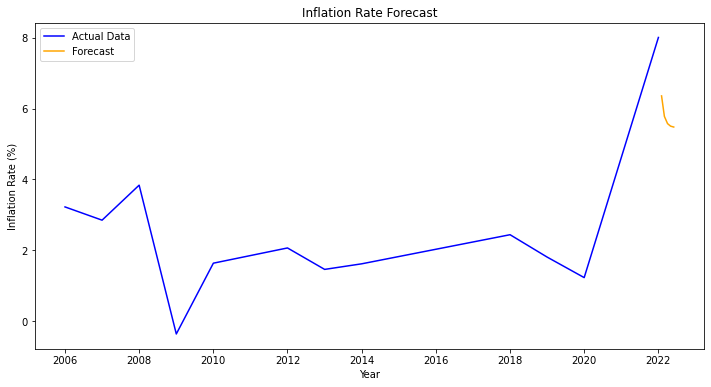

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(inflation_pd['InflationRate'][-20:], label='Actual Data', color='blue')

last_date_inflation = inflation_pd.index[-1]
future_dates_inflation = [last_date_inflation + pd.DateOffset(months=i) for i in range(1, 6)]

plt.plot(future_dates_inflation, forecast_inflation, label='Forecast', color='orange')

plt.title('Inflation Rate Forecast')
plt.xlabel('Year')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.show()
